In [1]:
import pandas as pd

from lets_plot import *


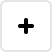
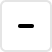
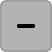
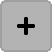
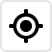
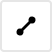
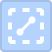
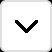
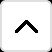
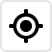
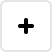
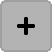
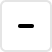
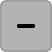
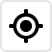
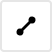
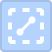
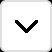
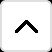
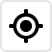

In [2]:
LetsPlot.setup_html()

In [3]:
def dataset_array_to_dataframe(dataset_array):
    df = pd.DataFrame.from_records([
        (j, i, a)
        for i, r in enumerate(dataset_array)
        for j, a in enumerate(r)
    ], columns=["x", "y", "h"])
    return df

def process_rows(df, step=1):
    def add_tails_to_row(subdf, y):
        xmin, xmax = subdf['x'].min(), subdf['x'].max()
        return pd.concat([
            subdf,
            pd.DataFrame({'x': [xmin - 1, xmax + 1], 'y': [y, y], 'h': [0, 0]})
        ], ignore_index=True)
    return pd.concat([
        add_tails_to_row(df[df['y'] == y], y) for y in range(df['y'].min(), df['y'].max() + 1, step)
    ]).sort_values(by=['y', 'x']).reset_index(drop=True)

def process_rows2(df, *, min_h, step_x=1, step_y=1):
    def add_tails_to_row(subdf, y):
        xs = [x for x in range(subdf['x'].min() - step_x, subdf['x'].max() + step_x + 1, step_x) if x not in subdf['x'].values]
        ys = [y] * len(xs)
        hs = [0] * len(xs)
        new_df = pd.concat([
            subdf,
            pd.DataFrame({'x': xs, 'y': ys, 'h': hs})
        ], ignore_index=True).sort_values(by='x').reset_index(drop=True)
        xs = []
        ys = []
        hs = []
        for i, (_x, _y, _h) in new_df.iterrows():
            if _h > 0:
                xs.append(_x)
                ys.append(_y)
                hs.append(_h)
            else:
                if i > 0 and new_df.iloc[i - 1]['h'] > 0:
                    xs.append(_x)
                    ys.append(_y)
                    hs.append(min_h)
                elif i < new_df.shape[0] - 1 and new_df.iloc[i + 1]['h'] > 0:
                    xs.append(_x)
                    ys.append(_y)
                    hs.append(min_h)
                else:
                    xs.append(_x)
                    ys.append(_y)
                    hs.append(0)
        return pd.DataFrame({'x': xs, 'y': ys, 'h': hs})
    return pd.concat([
        add_tails_to_row(df[df['y'] == y], y) for y in range(df['y'].min(), df['y'].max() + 1, step_y)
    ]).sort_values(by=['y', 'x']).reset_index(drop=True)

In [4]:
raw_data_array = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/new_zealand.csv", header=None).to_numpy()
raw_df = dataset_array_to_dataframe(raw_data_array)
print(raw_df.shape)
raw_df.head()

(240000, 3)


x  y    h
0  0  0  0.0
1  1  0  0.0
2  2  0  0.0
3  3  0  0.0
4  4  0  0.0

In [5]:
df = process_rows(raw_df[raw_df["h"] > 0], 2)
bbox = dict(xmin=df['x'].min(), ymin=df['y'].min(), xmax=df['x'].max(), ymax=df['y'].max())
print(df.shape)
df.head()

(4243, 3)


x  y           h
0  432  6    0.000000
1  433  6  114.518776
2  435  6  180.143860
3  436  6    0.000000
4  420  8    0.000000

In [6]:
min_h = raw_df[raw_df['h'] > 0].describe()['h']['min']
df2 = process_rows2(raw_df[raw_df["h"] > 0], min_h=min_h, step_x=2, step_y=2)
print(df2.shape)
df2.head()

(13767, 3)


x    y           h
0  431.0  6.0    0.258861
1  433.0  6.0  114.518776
2  435.0  6.0  180.143860
3  437.0  6.0    0.258861
4  419.0  8.0    0.258861

## Raw Data

### `geom_tile()`

In [7]:
ggplot(raw_df[raw_df['h'] > 0]) + \
    geom_tile(aes('x', 'y', fill='h')) + \
    scale_y_continuous(trans='reverse') + \
    ggtb()

### `geom_area_ridges()`: skip zero heights in dataset

In [8]:
ggplot(raw_df[raw_df['h'] > 0]) + \
    geom_area_ridges(aes('x', 'y', height='h'), stat='identity', scale=.005) + \
    scale_y_continuous(trans='reverse')

### `geom_area_ridges()`: skip zero heights with `min_height`

In [9]:
ggplot(raw_df) + \
    geom_area_ridges(aes('x', 'y', height='h'),
                     stat='identity', scale=.005, min_height=.1, sampling=sampling_pick(500_000)) + \
    scale_y_continuous(trans='reverse')

### `geom_area_ridges()`: prepare data v1

In [10]:
ggplot(df) + \
    geom_area_ridges(aes("x", "y", height="h"), \
                     stat='identity', scale=.005, \
                     sampling=sampling_pick(500_000)) + \
    scale_y_continuous(trans='reverse')

### `geom_area_ridges()`: prepare data v2

In [11]:
ggplot(df2) + \
    geom_area_ridges(aes("x", "y", height="h"), \
                     stat='identity', min_height=min_h, scale=.005, \
                     sampling=sampling_pick(500_000)) + \
    scale_y_continuous(trans='reverse')